In [14]:
import yfinance as yf

stock_tickers = ['META','NFLX','NVDA']
database = yf.download(stock_tickers,start='2020-01-01',end='2024-06-30',auto_adjust=True)
database = database['Close']
data = database.dropna().pct_change(1).dropna()
data

[*********************100%***********************]  3 of 3 completed


Ticker,META,NFLX,NVDA
Date,,,
2020-01-03,-0.005291,-0.011855,-0.016006
2020-01-06,0.018834,0.030469,0.004194
2020-01-07,0.002164,-0.015127,0.012107
2020-01-08,0.010138,0.025729,0.001875
2020-01-09,0.014311,-0.010611,0.010983
...,...,...,...
2024-06-24,0.008347,-0.024923,-0.066840
2024-06-25,0.023431,0.005067,0.067564
2024-06-26,0.004935,0.007852,0.002459


In [15]:
from numpy import median
from scipy.stats import f


for i in stock_tickers:
    data[f"pct {i}"] = data[i].pct_change(1)
    data[f"SMA3 {i}"] = data[i].rolling(3).mean().shift(1)
    data[f"SMA12 {i}"] = data[i].rolling(12).mean().shift(1)
    data[f"Momentum Factor {i}"] = data[f"SMA3 {i}"] - data[f"SMA12 {i}"]
    
#so now creating a vector function 
validation_score = 0.3

columns = [f"Momentum Factor {i}" for i in stock_tickers]

train_size =int(len(data)*(1-validation_score))
train_data = data.iloc[:train_size,:]
test_data = data.iloc[train_size:,:]
#creating a vector function

train_data_mean = train_data[columns].mean()
train_data_std = train_data[columns].std()

#now creating the z_scores

train_data.loc[:, columns] = (train_data[columns] - train_data_mean) / train_data_std
test_data.loc[:, columns] = (test_data[columns] - train_data_mean) / train_data_std

median = train_data[columns].median()

test_data = test_data.copy()

for i in range(len(columns)):
    signal_col = f"Signal {columns[i]}"
    profit_col = f"Profit {columns[i]}"
    
    # Initialize the Signal column to 0
    test_data.loc[:, signal_col] = 0
    
    # Assign -1 and 1 based on the median value
    test_data.loc[test_data[columns[i]] < median.iloc[i], signal_col] = -1
    test_data.loc[test_data[columns[i]] > median.iloc[i], signal_col] = 1
    
    # Calculate Profit column
    test_data.loc[:, profit_col] = (test_data[signal_col].shift(1) * test_data[f"pct {stock_tickers[i]}"])
    
print(test_data[[f"Signal {columns[i]}" for i in range(len(columns))]])


Ticker      Signal Momentum Factor META  Signal Momentum Factor NFLX  \
Date                                                                   
2023-02-23                            1                           -1   
2023-02-24                            1                           -1   
2023-02-27                            1                           -1   
2023-02-28                            1                           -1   
2023-03-01                            1                            1   
...                                 ...                          ...   
2024-06-24                           -1                           -1   
2024-06-25                           -1                           -1   
2024-06-26                            1                           -1   
2024-06-27                            1                           -1   
2024-06-28                            1                            1   

Ticker      Signal Momentum Factor NVDA  
Date                 

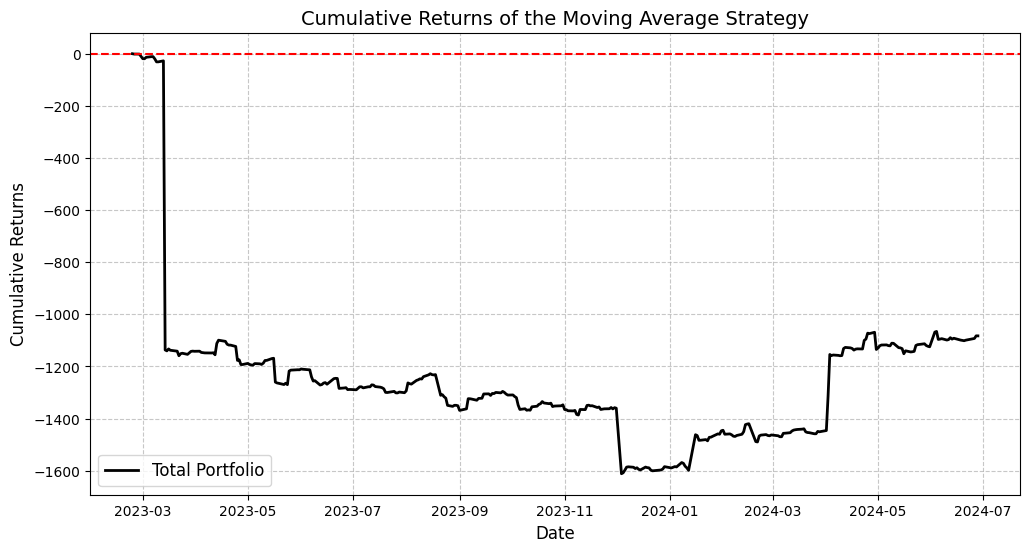

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Replace NaN and infinite values
profit_columns = [f"Profit {col}" for col in columns]
test_data[profit_columns] = test_data[profit_columns].fillna(0)
test_data[profit_columns] = test_data[profit_columns].replace([np.inf, -np.inf], 0)

# Calculate cumulative returns for the portfolio
cumulative_returns = test_data[profit_columns].sum(axis=1).cumsum()

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns, color='black', linewidth=2, label='Total Portfolio')

# Add a horizontal red line at y=0
plt.axhline(y=0, color='red', linestyle='--', linewidth=1.5)

# Add labels, title, and legend
plt.title('Cumulative Returns of the Moving Average Strategy', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Returns', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
